<a href="https://colab.research.google.com/github/shashwatrathod/MultipleLinearRegression/blob/master/MultipleLinearRegressionGradientDescent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiple Linear Regression without using libraries

Here is my implementation of multiple linear regression using gradient descent and MSE as cost function.

Dataset: https://www.kaggle.com/schirmerchad/bostonhoustingmlnd/data#

In [0]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import pickle
import time

In [290]:
dataset = pd.read_csv('housing.csv')
print(dataset.shape)

(489, 4)


In [291]:
X = dataset.iloc[:,:-1]
y = dataset.iloc[:,-1]
print(X.head())
print(y.head())

      RM  LSTAT  PTRATIO
0  6.575   4.98     15.3
1  6.421   9.14     17.8
2  7.185   4.03     17.8
3  6.998   2.94     18.7
4  7.147   5.33     18.7
0    504000.0
1    453600.0
2    728700.0
3    701400.0
4    760200.0
Name: MEDV, dtype: float64


In [292]:
class Normalizer:
  def __init__(self):
    self.normalization_factor = []

  def normalize(self,X):
    if(len(X.shape)==2):
      for col in range(X.shape[1]):
        self.normalization_factor.append(np.max(X.iloc[:,col].values))
        X.iloc[:,col] = X.iloc[:,col] / np.max(X.iloc[:,col])
    elif(len(X.shape)==1):
      self.normalization_factor.append(np.max(X.iloc[:]))
      X.iloc[:] = X.iloc[:] / np.max(X.iloc[:])
    
    return X

  def inv_normalize(self,X):
    X = X*self.normalization_factor
    return X

norm_x = Normalizer()
norm_y = Normalizer()

X = norm_x.normalize(X)
y = norm_y.normalize(y)

with open("models/norm_x.pickle",'wb') as file:
  pickle.dump(norm_x,file)
with open("models/norm_y.picklle",'wb') as file:
  pickle.dump(norm_y,file)  

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [0]:
def split_test_train(X,y,ratio=0.2):
  data = X.join(y)
  np.random.shuffle(data.values)
  no_rows = data.shape[0]
  split = int(no_rows*ratio)
  train_set = []
  test_set = []
  for i in range(no_rows):
    if i <= split:
      test_set.append(list(data.iloc[i].values))
      
    else:
      train_set.append(list(data.iloc[i].values))

    train_x = []
    train_y = []
    test_x = []
    test_y = []

    for i in range(len(train_set)):
      train_x.append(train_set[i][:-1])
      train_y.append(train_set[i][-1])
    for i in range(len(test_set)):
      test_x.append(test_set[i][:-1])
      test_y.append(test_set[i][-1])
  
  return train_x, train_y, test_x, test_y

train_x, train_y, test_x, test_y = split_test_train(X,y)

Here, our hypothesis is of the form: <br>
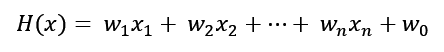
<br>
Where 'n' is the total number of attributes.

<p>
We use mean squared error as the cost function. Hence,<br>

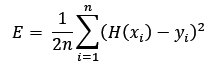
<br>
Based on this we calculate the gradients as:<br>
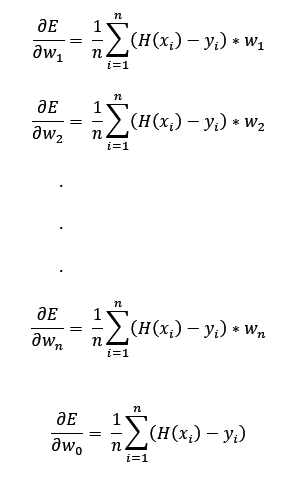
<br>
Therefore, the change in weights can be given as:<br>
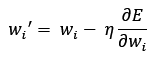
<br>
Where η is the learning rate.

In [0]:
class LinearRegression:
  def __init__(self):
    self.weights = []
  
  def train(self,train_x, train_y, test_x, test_y, learning_rate = 0.01, summary = True):
    w0 = 1
    w = np.ones(len(train_x[1]))
    losses = []
    val_loss = []
    Hs = []
    m = len(train_x)
    learn = True
    epoch = 1
    while(learn):
      H = []
      loss = []
      for i in range(m):
        H.append(sum(train_x[i]*w) + w0)
        loss.append((H[i]-train_y[i])**2)
      losses.append( sum(loss)/(2*m) )

      H_v = []
      loss_v = []
      for i in range(len(test_x)):
        H_v.append(sum(test_x[i]*w) + w0)
        loss_v.append((H_v[i]-test_y[i])**2)
      val_loss.append( sum(loss_v)/(2*(len(test_x))) ) 

      if(abs(losses[len(losses)-1] - losses[len(losses)-2]) < 0.0001 and len(losses)>3):
        learn = False
        self.weights = list(w)
        self.weights.append(w0)
        print(self.weights)
        break
      else:
        for j in range(len(w)):
          adada = []
          for i in range(m):
            adada.append((H[i]-train_y[i])*w[j])
          del_w = sum(adada) / m
          w[j] = w[j] - (learning_rate*del_w)
      
        ababa = []
        for i in range(m):
          ababa.append(H[i]-train_y[i])
        del_w0 = sum(ababa)/m
        w0 = w0 - (learning_rate*del_w0)

      print(f"Epoch : {epoch}")
      print(f"loss : {losses[epoch-1]}")
      print(f"val_loss : {val_loss[epoch-1]} \n")
      print("*********************************************************************** \n")
      epoch += 1

    if(summary):
      plt.figure(1)
      
      plt.plot([x for x in range(len(losses))],losses)
      plt.xlabel("Epoch")
      plt.ylabel("Loss")
      plt.title("Epoch vs Loss")

      plt.figure(2)
      plt.plot([x for x in range(len(val_loss))],val_loss)
      plt.xlabel("Epoch")
      plt.ylabel("Loss")
      plt.title("Epoch vs val_loss")
      plt.show()
    
    name = f"model-{int(time.time())}.pickle"
    with open(f"models/{name}",'wb') as file:
      pickle.dump(self,file)
  
  
  def predict(self,X):
    if(len(X[1])==len(self.weights)-1):
      y = []
      w = self.weights
      w0 = w.pop()
      w = np.asarray(w)
      for i in range(len(X)):
        y.append(sum(X[i]*w)+w0)
      
      return y
    else:
      print("Incorrect shape!")
      return False

Streaming output truncated to the last 5000 lines.
Epoch : 337
loss : 0.6368530942885041
val_loss : 0.6302826712856647 

*********************************************************************** 

Epoch : 338
loss : 0.6342860713045686
val_loss : 0.6277323530148763 

*********************************************************************** 

Epoch : 339
loss : 0.631731260405301
val_loss : 0.6251942165373761 

*********************************************************************** 

Epoch : 340
loss : 0.6291885934286053
val_loss : 0.6226681937321018 

*********************************************************************** 

Epoch : 341
loss : 0.6266580026648197
val_loss : 0.6201542169305935 

*********************************************************************** 

Epoch : 342
loss : 0.6241394208531591
val_loss : 0.6176522189134322 

*********************************************************************** 

Epoch : 343
loss : 0.6216327811781948
val_loss : 0.6151621329067167 

****************

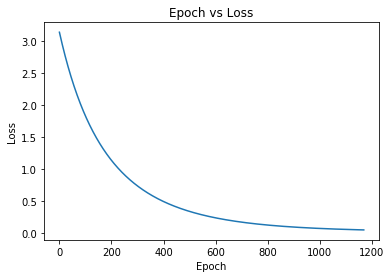

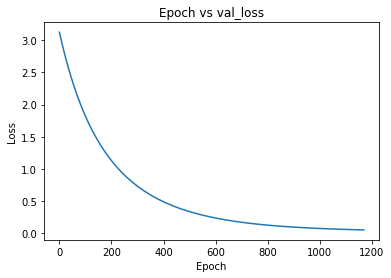

In [295]:
model = LinearRegression()
model.train(train_x,train_y,test_x,test_y,learning_rate=0.001)

In [0]:
y_pred = model.predict(test_x)

In [297]:
print("Y Test")
print(test_y[:10])
print("Y pred")
print(y_pred[:10])

Y Test
[0.5942622950819673, 0.3442622950819672, 0.3401639344262295, 0.45901639344262296, 0.2827868852459016, 0.47540983606557374, 0.17418032786885246, 0.7377049180327869, 0.5758196721311475, 0.3483606557377049]
Y pred
[0.5751445613909558, 0.6951437943557526, 0.7164769065993344, 0.7047222984371846, 0.8553900502005477, 0.7295228479196371, 0.7527647151238, 0.5871792366274365, 0.6531217521106989, 0.6330895832230439]
